  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ivad973n
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ivad973n
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-85qbvwy8
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-85qbvwy8
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 60.4MiB/s]


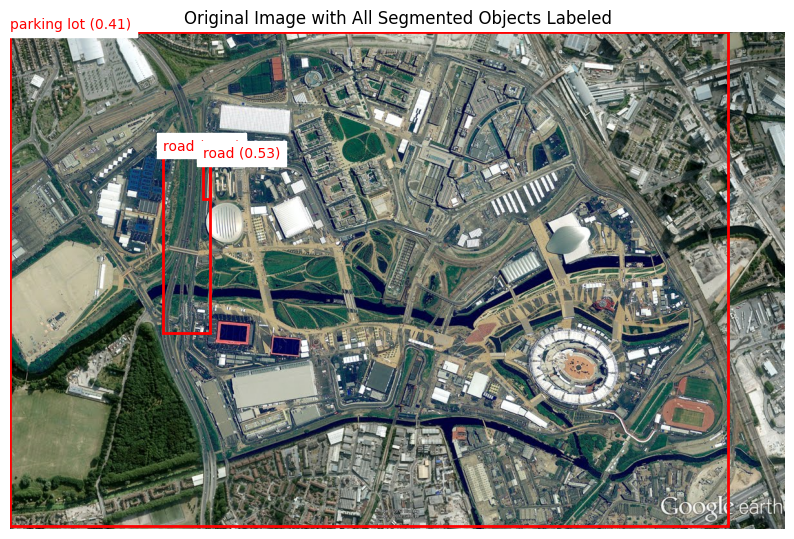

In [1]:
# Install dependencies (once per session)
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install ftfy regex tqdm git+https://github.com/openai/CLIP.git supervision
!wget -O sam_vit_b.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
import requests
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import clip
from segment_anything import sam_model_registry, SamPredictor

# Load SAM model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b.pth").to(device)
predictor = SamPredictor(sam)

# Load CLIP model
model_clip, preprocess_clip = clip.load("ViT-B/32", device=device)

# Load sample image
url = "https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEhgTEoQ9bEyFxk2wLUOFOwSus0kLO20CXO5rpF3LYWOavOwVoVztjChdEQoSq7D7r4Tc3hsy4rMPbjKwBYxXAJMoKWV8xgh_k5I94lEMJn8d3rKW8yE2gOw3xwFeF_wCJeDvI1vZHGtxSta/s1600/Olympic+Park.jpeg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
image_np = np.array(image)
predictor.set_image(image_np)

# Get multiple masks from SAM
input_point = np.array([[300, 200]])
input_label = np.array([1])
masks, scores, _ = predictor.predict(point_coords=input_point,
                                     point_labels=input_label,
                                     multimask_output=True)

# Define labels for CLIP
label_list = ["building", "road", "solar panel", "tree", "car", "parking lot"]
text_inputs = clip.tokenize(label_list).to(device)

# Set up drawing
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_np)

# Loop over each mask
for i, mask in enumerate(masks):
    ys, xs = np.where(mask)
    if len(xs) == 0 or len(ys) == 0:
        continue

    xmin, xmax, ymin, ymax = xs.min(), xs.max(), ys.min(), ys.max()
    crop = image.crop((xmin, ymin, xmax, ymax))
    img_input = preprocess_clip(crop).unsqueeze(0).to(device)

    with torch.no_grad():
        img_feat = model_clip.encode_image(img_input)
        txt_feat = model_clip.encode_text(text_inputs)
        probs = (img_feat @ txt_feat.T).softmax(dim=-1)

    label_id = probs.argmax().item()
    label = label_list[label_id]
    confidence = probs[0][label_id].item()

    # Draw mask overlay and label
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, ymin - 5, f"{label} ({confidence:.2f})",
            color='red', fontsize=10, backgroundcolor='white')

ax.set_title("Original Image with All Segmented Objects Labeled")
ax.axis('off')
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.6 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 165MB/s]



image 1/1 /kaggle/working/satellite.jpg: 416x640 1 clock, 178.8ms
Speed: 12.3ms preprocess, 178.8ms inference, 6.9ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs/detect/predict


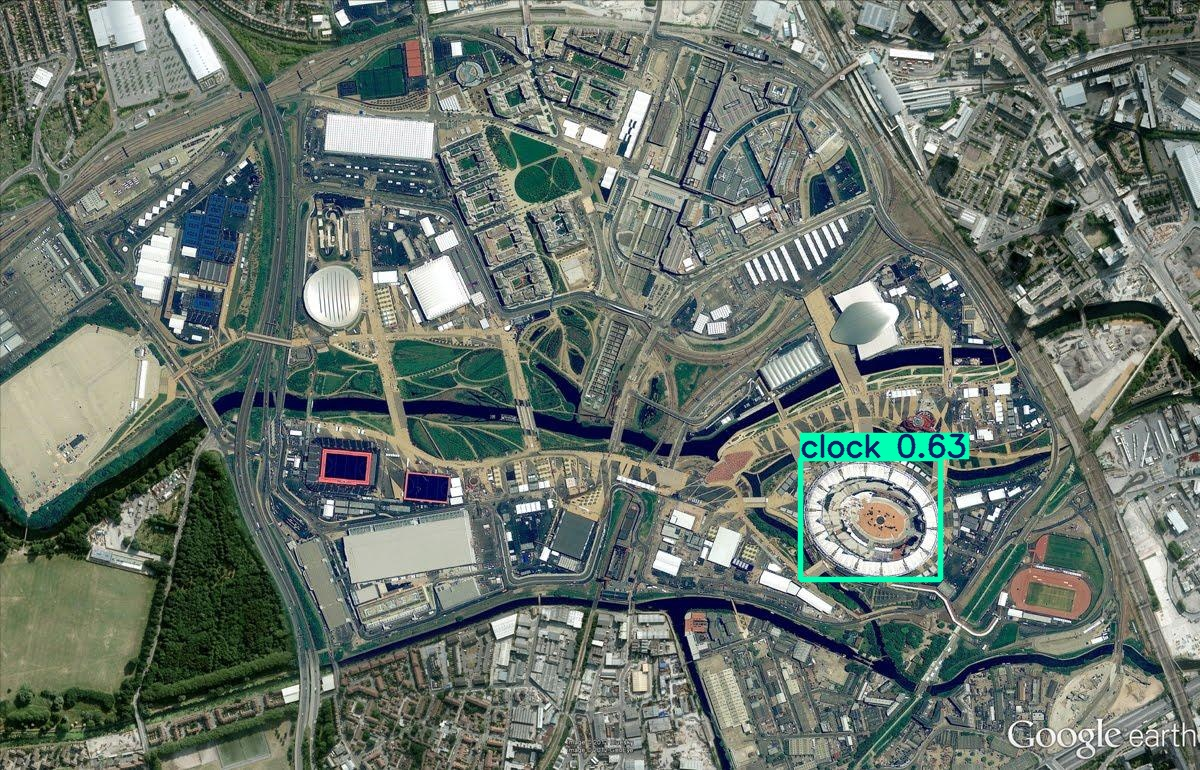

In [2]:
# 1. Install YOLOv8
!pip install ultralytics

# 2. Import and Load Pretrained Model
from ultralytics import YOLO
model = YOLO('yolov8n.pt')  # You can use yolov8m.pt or yolov8s.pt too

# 3. Download a satellite test image
import requests
from PIL import Image
url = "https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEhgTEoQ9bEyFxk2wLUOFOwSus0kLO20CXO5rpF3LYWOavOwVoVztjChdEQoSq7D7r4Tc3hsy4rMPbjKwBYxXAJMoKWV8xgh_k5I94lEMJn8d3rKW8yE2gOw3xwFeF_wCJeDvI1vZHGtxSta/s1600/Olympic+Park.jpeg"
image = Image.open(requests.get(url, stream=True).raw)
image.save("satellite.jpg")

# 4. Run inference
results = model.predict(source="satellite.jpg", save=True, conf=0.25)

# 5. Show the result
from IPython.display import Image as IPImage
IPImage(filename='runs/detect/predict/satellite.jpg')
